# Healthcare Provider Segmentation Analysis

In this notebook, we will explore how to run a segmentation analysis on the providers to see if we can make meaningful groupings of providers.


In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

/Users/nataliaclark/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# load the data
df = pd.read_excel('datos_ie.xlsx')
df.head()

,npi,countyID,census_tract,zip5,service_year,service_quarter,standard_services_claims,tele_services_claims,total_claims,standard_services_patients,tele_services_patients,total_patients,standard_services_claims_year,tele_services_claims_year,total_claims_year,standard_services_patients_year,tele_services_patients_year,total_patients_year,standard_services_psychotherapy_claims,tele_services_psychotherapy_claims,total_psychotherapy_claims,standard_services_psychotherapy_patients,tele_services_psychotherapy_patients,total_psychotherapy_patients,standard_services_psychotherapy_claims_year,tele_services_psychotherapy_claims_year,total_psychotherapy_claims_year,standard_services_psychotherapy_patients_year,tele_services_psychotherapy_patients_year,total_psychotherapy_patients_year,NPI_Deactivation_Reason_Code,NPI_Deactivation_Date,NPI_Reactivation_Date,Healthcare_Provider_Taxonomy_Code_1,Grouping_1,Classification_1,Specialization_1,Display_Name_1,%psychotherapy_claims,%teleService_claims,%tele_psychotherapy_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,%psychotherapy_claims_year,%teleService_claims_year,%tele_psychotherapy_claims_year,%psychotherapy_patients_year,%stdService_patients_year,%teleService_patients_year,%tele_psychotherapy_patients_year,psychotherapy_provider_through_taxonomy,provided_psychotherapy,psychotherapy_provider,countyname,urbanity,lat,long,transport_access,broadband_access,total_medicaid_claims,total_medicaid_patients,provider_size,Entity_Type_Code,AH_Sign language services for the deaf and hard of hearing,EN_English,SP_Spanish,NX_American Indian or Alaska Native languages,FX_Other languages (excluding Spanish),F4_Arabic,F17_Any Chinese Language,F19_Creole,F25_Farsi,F28_French,F30_German,F31_Greek,F35_Hebrew,F36_Hindi,F37_Hmong,F42_Italian,F43_Japanese,F47_Korean,F66_Polish,F67_Portuguese,F70_Russian,F81_Tagalog,F92_Vietnamese,N24_Ojibwa,N40_Yupik,Spoken_Language_Accessibility,black_owned,latino_owned,lgbtq+_owned,veteran_owned,women_owned,owner_identification,planning_accepts_new_patients,business_status,working_hours_cleaned,Weekend Availability,Availability Before 8AM,Availability After 5PM,total_commercial_claims,total_commercial_patients,total_medicare_claims,total_medicare_patients,total_other_payers_claims,total_other_payers_patients,total_commercial_claims_year,total_commercial_patients_year,total_medicaid_claims_year,total_medicaid_patients_year,total_medicare_claims_year,total_medicare_patients_year,total_other_payers_claims_year,total_other_payers_patients_year
0,1,51,16.04,28348,2020,2,0,0,0,0,0,0,0,8,8,0,5,5,0,0,0,0,0,0,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.9,0.89,0,0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0,0,0,0,8,2,0,0,0,0,0,0,16,4
1,1,51,16.04,28348,2020,1,0,0,0,0,0,0,0,8,8,0,5,5,0,0,0,0,0,0,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.9,0.89,0,0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,51,16.04,28348,2020,3,0,2,2,0,2,2,0,8,8,0,5,5,0,2,2,0,2,2,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,1.0,1.0,1.

In [4]:
# exploring columns
df.columns

Index(['npi', 'countyID', 'census_tract', 'zip5', 'service_year',
       'service_quarter', 'standard_services_claims', 'tele_services_claims',
       'total_claims', 'standard_services_patients',
       ...
       'total_other_payers_claims', 'total_other_payers_patients',
       'total_commercial_claims_year', 'total_commercial_patients_year',
       'total_medicaid_claims_year', 'total_medicaid_patients_year',
       'total_medicare_claims_year', 'total_medicare_patients_year',
       'total_other_payers_claims_year', 'total_other_payers_patients_year'],
      dtype='object', length=117)

In [5]:
# Define aggregation functions for each column
agg_funcs = {
    'countyID': 'first',  # Use 'first' since these are likely the same per NPI
    'census_tract': 'first', # Use 'first' since these are likely the same per NPI
    'zip5': 'first', # Use 'first' since these are likely the same per NPI
    'standard_services_patients': 'median',  # Sum patients data
    'tele_services_patients': 'median', # Sum patients data
    'total_patients': 'median', # Median patients data
    'standard_services_patients_year': 'median', # Sum patients data
    'tele_services_patients_year': 'median', # Sum patients data
    'total_patients_year': 'median', # Median total patients per year
    'standard_services_psychotherapy_patients': 'median',
    'tele_services_psychotherapy_patients': 'median',
    'total_psychotherapy_patients': 'median',
    'standard_services_psychotherapy_patients_year': 'median',
    'tele_services_psychotherapy_patients_year': 'median',
    'total_psychotherapy_patients_year': 'median',
    'NPI_Deactivation_Reason_Code': 'first',
    'Healthcare_Provider_Taxonomy_Code_1': 'first',
    'Grouping_1': 'first',
    'Classification_1': 'first',
    'Specialization_1': 'first',
    'Display_Name_1': 'first',
    'psychotherapy_provider_through_taxonomy': 'first',
    'provided_psychotherapy': 'first',
    'psychotherapy_provider': 'first',
    'countyname': 'first',
    'urbanity': 'first',
    'lat': 'first',
    'long': 'first',
    'transport_access': 'first',
    'broadband_access': 'first',
    'total_medicaid_patients': 'median',
    'provider_size': 'first',
    'Entity_Type_Code': 'first',
    'AH_Sign language services for the deaf and hard of hearing': 'first',
    'EN_English': 'first',
    'SP_Spanish': 'first',
    'NX_American Indian or Alaska Native languages': 'first',
    'FX_Other languages (excluding Spanish)': 'first',
    'F4_Arabic':'first',
    'F17_Any Chinese Language': 'first',
    'F19_Creole': 'first',
    'F25_Farsi': 'first',
    'F28_French': 'first',
    'F30_German': 'first',
    'F31_Greek': 'first',
    'F35_Hebrew': 'first',
    'F36_Hindi': 'first',
    'F37_Hmong': 'first',
    'F42_Italian': 'first',
    'F43_Japanese': 'first',
    'F47_Korean': 'first',
    'F66_Polish': 'first',
    'F67_Portuguese': 'first',
    'F70_Russian': 'first',
    'F81_Tagalog': 'first',
    'F92_Vietnamese': 'first',
    'N24_Ojibwa': 'first',
    'N40_Yupik': 'first',
    'Spoken_Language_Accessibility': 'first',
    'black_owned': 'first',
    'latino_owned': 'first',
    'lgbtq+_owned': 'first',
    'veteran_owned': 'first',
    'women_owned': 'first',
    'owner_identification': 'first',
    'planning_accepts_new_patients': 'last',
    'business_status': 'last',
    'Weekend Availability': 'last',
    'Availability Before 8AM': 'last',
    'Availability After 5PM': 'last',
    'total_commercial_patients': 'median',
    'total_medicare_patients': 'median',
    'total_other_payers_patients': 'median',
    'total_commercial_patients_year': 'median',
    'total_medicaid_patients_year': 'median',
    'total_medicare_patients_year': 'median',
    'total_other_payers_patients_year': 'median'
}

# Aggregate the data
df_aggregated = df.groupby('npi').agg(agg_funcs).reset_index()

df_aggregated.head()


,npi,countyID,census_tract,zip5,standard_services_patients,tele_services_patients,total_patients,standard_services_patients_year,tele_services_patients_year,total_patients_year,standard_services_psychotherapy_patients,tele_services_psychotherapy_patients,total_psychotherapy_patients,standard_services_psychotherapy_patients_year,tele_services_psychotherapy_patients_year,total_psychotherapy_patients_year,NPI_Deactivation_Reason_Code,Healthcare_Provider_Taxonomy_Code_1,Grouping_1,Classification_1,Specialization_1,Display_Name_1,psychotherapy_provider_through_taxonomy,provided_psychotherapy,psychotherapy_provider,countyname,urbanity,lat,long,transport_access,broadband_access,total_medicaid_patients,provider_size,Entity_Type_Code,AH_Sign language services for the deaf and hard of hearing,EN_English,SP_Spanish,NX_American Indian or Alaska Native languages,FX_Other languages (excluding Spanish),F4_Arabic,F17_Any Chinese Language,F19_Creole,F25_Farsi,F28_French,F30_German,F31_Greek,F35_Hebrew,F36_Hindi,F37_Hmong,F42_Italian,F43_Japanese,F47_Korean,F66_Polish,F67_Portuguese,F70_Russian,F81_Tagalog,F92_Vietnamese,N24_Ojibwa,N40_Yupik,Spoken_Language_Accessibility,black_owned,latino_owned,lgbtq+_owned,veteran_owned,women_owned,owner_identification,planning_accepts_new_patients,business_status,Weekend Availability,Availability Before 8AM,Availability After 5PM,total_commercial_patients,total_medicare_patients,total_other_payers_patients,total_commercial_patients_year,total_medicaid_patients_year,total_medicare_patients_year,total_other_payers_patients_year
0,1,51,16.04,28348,1.0,0.0,2.0,4.0,2.0,5.0,1.0,0.0,2.0,4.0,2.0,5.0,NaN,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.900,0.89,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,71,328.00,28052,0.0,0.5,0.5,0.0,1.0,1.0,0.0,0.5,0.5,0.0,1.0,1.0,NaN,1041C0700X,Behavioral Health & Social Service Providers,Social Worker,Clinical,Clinical Social Worker,1,1,1,Gaston,Urban,35.258674,-81.180363,0.697,0.26,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,OPERATIONAL,No,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,81,153.02,27377,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,NaN,207QS0010X,Allopathic & Osteopathic Physicians,Family Medicine,Sports Medicine,Sports Medicine (Family Medicine) Physician,0,1,1,Guilford,Urban,36.063693,-79.599605,1.000,0.60,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,1,OPERATIONAL,No,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,119,23.00,28211,0.5,0.0,0.5,2.0,0.0,2.0,0.5,0.0,0.5,2.0,0.0,2.0,NaN,101YM0800X,Behavioral Health & Social Service Providers,Counselor,Mental Health,Mental Health Counselor,1,1,1,Mecklenburg,Urban,35.190731,-80.803579,0.985,0.53,0.0,Small,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,23,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,183,537.23,27615,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,101YP2500X,Behavioral Health & Social Service Providers,Counselor,Professional,Professional Counselor,1,1,1,Wake,Urban,35.897085,-78.650301,0.895,0.87,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_aggregated.shape

(11383, 78)

In [7]:
# getting rid of percentage columns 
df_cleaned = df_aggregated.drop([col for col in df_aggregated.columns if '%' in col], axis=1)
df_cleaned.columns

Index(['npi', 'countyID', 'census_tract', 'zip5', 'standard_services_patients',
       'tele_services_patients', 'total_patients',
       'standard_services_patients_year', 'tele_services_patients_year',
       'total_patients_year', 'standard_services_psychotherapy_patients',
       'tele_services_psychotherapy_patients', 'total_psychotherapy_patients',
       'standard_services_psychotherapy_patients_year',
       'tele_services_psychotherapy_patients_year',
       'total_psychotherapy_patients_year', 'NPI_Deactivation_Reason_Code',
       'Healthcare_Provider_Taxonomy_Code_1', 'Grouping_1', 'Classification_1',
       'Specialization_1', 'Display_Name_1',
       'psychotherapy_provider_through_taxonomy', 'provided_psychotherapy',
       'psychotherapy_provider', 'countyname', 'urbanity', 'lat', 'long',
       'transport_access', 'broadband_access', 'total_medicaid_patients',
       'provider_size', 'Entity_Type_Code',
       'AH_Sign language services for the deaf and hard of hearing

In [8]:
for col in df_cleaned.columns:
    # print col and dtype
    print(col, df_cleaned[col].dtype)
    print('______________________________________________________')

npi int64
______________________________________________________
countyID int64
______________________________________________________
census_tract float64
______________________________________________________
zip5 int64
______________________________________________________
standard_services_patients float64
______________________________________________________
tele_services_patients float64
______________________________________________________
total_patients float64
______________________________________________________
standard_services_patients_year float64
______________________________________________________
tele_services_patients_year float64
______________________________________________________
total_patients_year float64
______________________________________________________
standard_services_psychotherapy_patients float64
______________________________________________________
tele_services_psychotherapy_patients float64
___________________________________________________

In [9]:
df_cleaned.columns

Index(['npi', 'countyID', 'census_tract', 'zip5', 'standard_services_patients',
       'tele_services_patients', 'total_patients',
       'standard_services_patients_year', 'tele_services_patients_year',
       'total_patients_year', 'standard_services_psychotherapy_patients',
       'tele_services_psychotherapy_patients', 'total_psychotherapy_patients',
       'standard_services_psychotherapy_patients_year',
       'tele_services_psychotherapy_patients_year',
       'total_psychotherapy_patients_year', 'NPI_Deactivation_Reason_Code',
       'Healthcare_Provider_Taxonomy_Code_1', 'Grouping_1', 'Classification_1',
       'Specialization_1', 'Display_Name_1',
       'psychotherapy_provider_through_taxonomy', 'provided_psychotherapy',
       'psychotherapy_provider', 'countyname', 'urbanity', 'lat', 'long',
       'transport_access', 'broadband_access', 'total_medicaid_patients',
       'provider_size', 'Entity_Type_Code',
       'AH_Sign language services for the deaf and hard of hearing

In [10]:
language_columns = ['AH_Sign language services for the deaf and hard of hearing',
       'EN_English', 'SP_Spanish',
       'NX_American Indian or Alaska Native languages',
       'FX_Other languages (excluding Spanish)', 'F4_Arabic',
       'F17_Any Chinese Language', 'F19_Creole', 'F25_Farsi', 'F28_French',
       'F30_German', 'F31_Greek', 'F35_Hebrew', 'F36_Hindi', 'F37_Hmong',
       'F42_Italian', 'F43_Japanese', 'F47_Korean', 'F66_Polish',
       'F67_Portuguese', 'F70_Russian', 'F81_Tagalog', 'F92_Vietnamese',
       'N24_Ojibwa', 'N40_Yupik', 'Spoken_Language_Accessibility']

# Checking for value counts of language columns
for col in language_columns:
    print(col)
    print(df_cleaned[col].value_counts())
    print('______________________________________________________')


AH_Sign language services for the deaf and hard of hearing
AH_Sign language services for the deaf and hard of hearing
0    11292
1       91
Name: count, dtype: int64
______________________________________________________
EN_English
EN_English
0    11341
1       42
Name: count, dtype: int64
______________________________________________________
SP_Spanish
SP_Spanish
0    11288
1       95
Name: count, dtype: int64
______________________________________________________
NX_American Indian or Alaska Native languages
NX_American Indian or Alaska Native languages
0    11302
1       81
Name: count, dtype: int64
______________________________________________________
FX_Other languages (excluding Spanish)
FX_Other languages (excluding Spanish)
0    11302
1       81
Name: count, dtype: int64
______________________________________________________
F4_Arabic
F4_Arabic
0    11302
1       81
Name: count, dtype: int64
______________________________________________________
F17_Any Chinese Language
F17_A

In [11]:
# printing null counts per column in for loop
for col in df_cleaned.columns:
    print(col, df_cleaned[col].isnull().sum())
    print('______________________________________________________')

npi 0
______________________________________________________
countyID 0
______________________________________________________
census_tract 0
______________________________________________________
zip5 0
______________________________________________________
standard_services_patients 0
______________________________________________________
tele_services_patients 0
______________________________________________________
total_patients 0
______________________________________________________
standard_services_patients_year 0
______________________________________________________
tele_services_patients_year 0
______________________________________________________
total_patients_year 0
______________________________________________________
standard_services_psychotherapy_patients 0
______________________________________________________
tele_services_psychotherapy_patients 0
______________________________________________________
total_psychotherapy_patients 0
_______________________________

In [12]:
# Seeing which columns are significant for clustering 
df_cleaned.columns

Index(['npi', 'countyID', 'census_tract', 'zip5', 'standard_services_patients',
       'tele_services_patients', 'total_patients',
       'standard_services_patients_year', 'tele_services_patients_year',
       'total_patients_year', 'standard_services_psychotherapy_patients',
       'tele_services_psychotherapy_patients', 'total_psychotherapy_patients',
       'standard_services_psychotherapy_patients_year',
       'tele_services_psychotherapy_patients_year',
       'total_psychotherapy_patients_year', 'NPI_Deactivation_Reason_Code',
       'Healthcare_Provider_Taxonomy_Code_1', 'Grouping_1', 'Classification_1',
       'Specialization_1', 'Display_Name_1',
       'psychotherapy_provider_through_taxonomy', 'provided_psychotherapy',
       'psychotherapy_provider', 'countyname', 'urbanity', 'lat', 'long',
       'transport_access', 'broadband_access', 'total_medicaid_patients',
       'provider_size', 'Entity_Type_Code',
       'AH_Sign language services for the deaf and hard of hearing

In [13]:
# if the only values are 0 and 1 for a column, put the type of the col to boolean 
for col in df_cleaned.columns:
    if list(df_cleaned[col].unique()) in [[0, 1], [1, 0]]:
        df_cleaned[col] = df_cleaned[col].astype(bool)

In [14]:
df_cleaned.columns

Index(['npi', 'countyID', 'census_tract', 'zip5', 'standard_services_patients',
       'tele_services_patients', 'total_patients',
       'standard_services_patients_year', 'tele_services_patients_year',
       'total_patients_year', 'standard_services_psychotherapy_patients',
       'tele_services_psychotherapy_patients', 'total_psychotherapy_patients',
       'standard_services_psychotherapy_patients_year',
       'tele_services_psychotherapy_patients_year',
       'total_psychotherapy_patients_year', 'NPI_Deactivation_Reason_Code',
       'Healthcare_Provider_Taxonomy_Code_1', 'Grouping_1', 'Classification_1',
       'Specialization_1', 'Display_Name_1',
       'psychotherapy_provider_through_taxonomy', 'provided_psychotherapy',
       'psychotherapy_provider', 'countyname', 'urbanity', 'lat', 'long',
       'transport_access', 'broadband_access', 'total_medicaid_patients',
       'provider_size', 'Entity_Type_Code',
       'AH_Sign language services for the deaf and hard of hearing

In [15]:
# important columns for clustering
important_columns = ['npi',
       'total_patients_year', 
       'Grouping_1', 
       # 'Classification_1', 'Specialization_1', 'Display_Name_1',
       'provided_psychotherapy',
       'countyname', 'urbanity',
       'provider_size',
       'Spoken_Language_Accessibility',
       'black_owned', 'latino_owned', 'lgbtq+_owned', 'veteran_owned',
       'women_owned', 'planning_accepts_new_patients',
       'business_status', 'Weekend Availability', 'Availability Before 8AM',
       'Availability After 5PM']

In [16]:
df_final = df_cleaned[important_columns]

In [17]:
df_final.head()

,npi,total_patients_year,Grouping_1,provided_psychotherapy,countyname,urbanity,provider_size,Spoken_Language_Accessibility,black_owned,latino_owned,lgbtq+_owned,veteran_owned,women_owned,planning_accepts_new_patients,business_status,Weekend Availability,Availability Before 8AM,Availability After 5PM
0,1,5.0,Behavioral Health & Social Service Providers,1,Cumberland,Urban,Small,0,False,False,False,False,False,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available
1,2,1.0,Behavioral Health & Social Service Providers,1,Gaston,Urban,Small,0,False,False,False,False,False,False,OPERATIONAL,No,No,No
2,3,2.0,Allopathic & Osteopathic Physicians,1,Guilford,Urban,Small,0,False,False,False,False,False,True,OPERATIONAL,No,No,No
3,4,2.0,Behavioral Health & Social Service Providers,1,Mecklenburg,Urban,Small,23,False,False,False,False,False,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available
4,5,1.0,Behavioral Health & Social Service Providers,1,Wake,Urban,Small,0,False,False,False,False,False,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available


In [18]:
# converting final df to csv and saving 
df_final.to_csv('segmentation_df.csv', index=False)

In [19]:
# Extract features data
X = df_final.copy()

# Standardize the data
categorical_columns = X.select_dtypes(include='object').columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# encoding categorical columns
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[categorical_columns]).toarray()

# scaling numerical columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numeric_columns])

# Concatenate the encoded categorical columns and the scaled numerical columns
X_final = np.concatenate([X_encoded, X_scaled], axis=1)


In [20]:
X_final.shape

(11383, 140)

In [21]:
# converting X_final to df 
X_final_df = pd.DataFrame(X_final, columns = list(encoder.get_feature_names_out()) + list(numeric_columns))

In [22]:
X_final_df.head()

,Grouping_1_Allopathic & Osteopathic Physicians,Grouping_1_Ambulatory Health Care Facilities,Grouping_1_Behavioral Health & Social Service Providers,Grouping_1_Chiropractic Providers,Grouping_1_Dental Providers,Grouping_1_Dietary & Nutritional Service Providers,Grouping_1_Eye and Vision Services Providers,Grouping_1_Hospital Units,Grouping_1_Hospitals,Grouping_1_Laboratories,Grouping_1_Managed Care Organizations,Grouping_1_Nursing & Custodial Care Facilities,Grouping_1_Nursing Service Providers,Grouping_1_Nursing Service Related Providers,Grouping_1_Other Service Providers,Grouping_1_Pharmacy Service Providers,Grouping_1_Physician Assistants & Advanced Practice Nursing Providers,Grouping_1_Podiatric Medicine & Surgery Service Providers,Grouping_1_Residential Treatment Facilities,"Grouping_1_Respiratory, Developmental, Rehabilitative and Restorative Service Providers",Grouping_1_Respite Care Facility,"Grouping_1_Speech, Language and Hearing Service Providers","Grouping_1_Student, Health Care",Grouping_1_Suppliers,Grouping_1_Transportation Services,countyname_Alexander,countyname_Alleghany,countyname_Anson,countyname_Ashe,countyname_Avery,countyname_Beaufort,countyname_Bertie,countyname_Bladen,countyname_Brunswick,countyname_Buncombe,countyname_Burke,countyname_Cabarrus,countyname_Caldwell,countyname_Carteret,countyname_Caswell,countyname_Catawba,countyname_Chatham,countyname_Cherokee,countyname_Chowan,countyname_Clay,countyname_Cleveland,countyname_Columbus,countyname_Craven,countyname_Cumberland,countyname_Currituck,countyname_Dare,countyname_Davidson,countyname_Davie,countyname_Duplin,countyname_Durham,countyname_Edgecombe,countyname_Forsyth,countyname_Franklin,countyname_Gaston,countyname_Gates,countyname_Graham,countyname_Granville,countyname_Greene,countyname_Guilford,countyname_Halifax,countyname_Harnett,countyname_Haywood,countyname_Henderson,countyname_Hertford,countyname_Hoke,countyname_Hyde,countyname_Iredell,countyname_Jackson,countyname_Johnston,countyname_Jones,countyname_Lee,countyname_Lenoir,countyname_Lincoln,countyname_Macon,countyname_Madison,countyname_Martin,countyname_McDowell,countyname_Mecklenburg,countyname_Mitchell,countyname_Montgomery,countyname_Moore,countyname_Nash,countyname_New Hanover,countyname_Northampton,countyname_Onslow,countyname_Orange,countyname_Pamlico,countyname_Pasquotank,countyname_Pender,countyname_Perquimans,countyname_Person,countyname_Pitt,countyname_Polk,countyname_Randolph,countyname_Richmond,countyname_Robeson,countyname_Rockingham,countyname_Rowan,countyname_Rutherford,countyname_Sampson,countyname_Scotland,countyname_Stanly,countyname_Stokes,countyname_Surry,countyname_Swain,countyname_Transylvania,countyname_Tyrrell,countyname_Union,countyname_Vance,countyname_Wake,countyname_Warren,countyname_Washington,countyname_Watauga,countyname_Wayne,countyname_Wilkes,countyname_Wilson,countyname_Yadkin,countyname_Yancey,urbanity_Urban,provider_size_Small,business_status_CLOSED_TEMPORARILY,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_No,Weekend Availability_Only Saturday,Weekend Availability_Only Sunday,Weekend Availability_Yes,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_No,Availability After 5PM_Yes,npi,total_patients_year,provided_psychotherapy,Spoken_Language_Accessibility
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.731899,-0.064824,0.0,-0.087550
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [23]:
# checking where nan values and seeing whole output 
X_final_df.isnull().sum().sort_values(ascending=False).head(5)

Grouping_1_Allopathic & Osteopathic Physicians    0
countyname_Pitt                                   0
countyname_Orange                                 0
countyname_Pamlico                                0
countyname_Pasquotank                             0
dtype: int64

In [24]:
# checking for nonetype 
X_final_df.dtypes

Grouping_1_Allopathic & Osteopathic Physicians                                             float64
Grouping_1_Ambulatory Health Care Facilities                                               float64
Grouping_1_Behavioral Health & Social Service Providers                                    float64
Grouping_1_Chiropractic Providers                                                          float64
Grouping_1_Dental Providers                                                                float64
Grouping_1_Dietary & Nutritional Service Providers                                         float64
Grouping_1_Eye and Vision Services Providers                                               float64
Grouping_1_Hospital Units                                                                  float64
Grouping_1_Hospitals                                                                       float64
Grouping_1_Laboratories                                                                    float64
Grouping_1

In [25]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

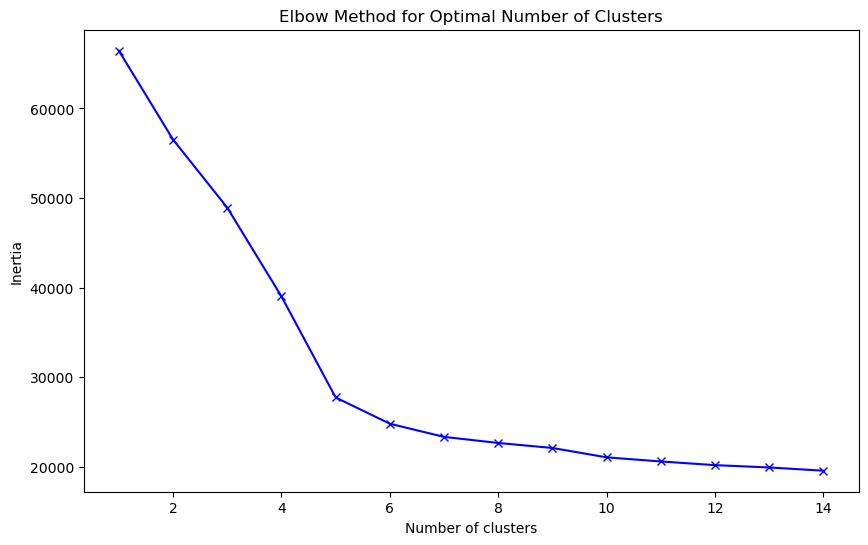

In [26]:
# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 15)
# cast df back to numpy array 
X_final = X_final_df.to_numpy()
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [29]:
# Fit K-means with the optimal number of clusters
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_final_df['kmeans_cluster'] = kmeans.fit_predict(X_final)

In [30]:
# using another segmentation algorithm 
from sklearn.cluster import AgglomerativeClustering

# Fit Agglomerative Clustering with the optimal number of clusters
agg = AgglomerativeClustering(n_clusters=optimal_k)
X_final_df['agg_cluster'] = agg.fit_predict(X_final)

# checking the clusters
X_final_df['agg_cluster'].value_counts()

agg_cluster
1    3852
4    3377
0    2972
2    1100
5      81
3       1
Name: count, dtype: int64